In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data handling
import pandas as pd
import numpy as np

# Data visualization
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

# Data Acquisition
import acquire

# Data Preparation
import prepare

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = acquire.get_telco_data()

In [4]:
df = prepare.prep_telco(df)

In [5]:
pd.set_option('display.max_columns', None)
df.head()

customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines online_security online_backup  \
0           Yes             No              No           Yes   
1           Yes            Yes              No            No   
2           Yes             No              No            No   
3           Yes             No              No           Yes   
4           Yes             No              No            No   

  device_protection tech_support streaming_tv streaming_movies  \
0                No          Yes          Yes               No   
1                No           No           No              Yes   
2               Yes           No           No               No   
3               Yes           No          Yes              Yes   
4                No          Yes          Yes               No   

  paperless_billing  monthly_charges  total_charges churn   contract_type  \
0               Yes             65.6         593.30    No        One year   
1                No             59.9         542.40    No  Month-to-month   
2               Yes             73.9         280.85   Yes  Month-to-month   
3               Yes             98.0        1237.85   Yes  Month-to-month   
4               Yes             83.9         267.40   Yes  Month-to-month   

       payment_type internet_service_type  gender_Male  partner_Yes  \
0      Mailed check                   DSL            0            1   
1      Mailed check                   DSL            1            0   
2  Electronic check           Fiber optic            1            0   
3  Electronic check           Fiber optic            1            1   
4      Mailed check           Fiber optic            0            1   

   dependents_Yes  phone_service_Yes  multiple_lines_No  multiple_lines_Yes  \
0               1                  1                  1                   0   
1               0                  1                  0                   1   
2               0                  1                  1                   0   
3               0                  1                  1                   0   
4               0                  1                  1                   0   

   online_security_No  online_security_Yes  online_backup_No  \
0                   1                    0                 0   
1                   1                    0                 1   
2                   1                    0                 1   
3                   1                    0                 0   
4                   1                    0                 1   

   online_backup_Yes  device_protection_No  device_protection_Yes  \
0                  1                     1                      0   
1                  0                     1                      0   
2                  0                     0                      1   
3                  1                     0                      1   
4                  0                     1                      0   

   tech_support_No  tech_support_Yes  streaming_tv_No  streaming_tv_Yes  \
0                0                 1                0                 1   
1                1                 0                1                 0   
2                1                 0                1                 0   
3                1                 0                0                 1   
4                0                 1                0                 1   

   streaming_movies_No  streaming_movies_Yes  paperless_billing_Yes  \
0                    1                     0                      1   
1                    0                     1         

In [9]:
df.churn.value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

In [6]:
# Split the data into train, validate, test

train, validate, test = prepare.split_telco_data(df)

In [7]:
# Check size of each dataset

train.shape, validate.shape, test.shape

((4500, 51), (1125, 51), (1407, 51))

## Exploratory Analysis: What's driving customers to churn?

In [7]:
train.churn_Yes.value_counts()

0    3304
1    1196
Name: churn_Yes, dtype: int64

In [8]:
# Percentage of churn

churn_rate = train.churn_Yes.mean()
print('Churn Rate on Training Set: {:.2f}'
     .format(churn_rate))

Churn Rate on Training Set: 0.27


Text(0.5, 1.0, 'Churn Rate: 26.58%')

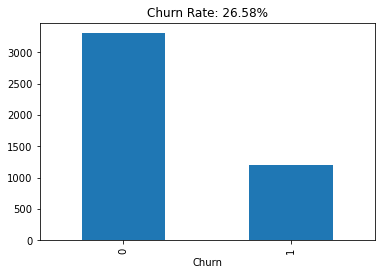

In [9]:
train.churn_Yes.value_counts().plot.bar()
plt.xlabel('Churn')
plt.title(f"Churn Rate: {churn_rate:.2%}")

***

### Question 1. Are customers churn or not depend on their contract type?

#### Contract Type vs. Churn

<AxesSubplot:xlabel='contract_type', ylabel='count'>

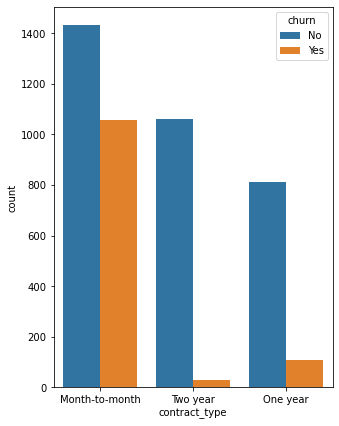

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(5,7))
sns.countplot(x="contract_type", data=train, hue="churn")

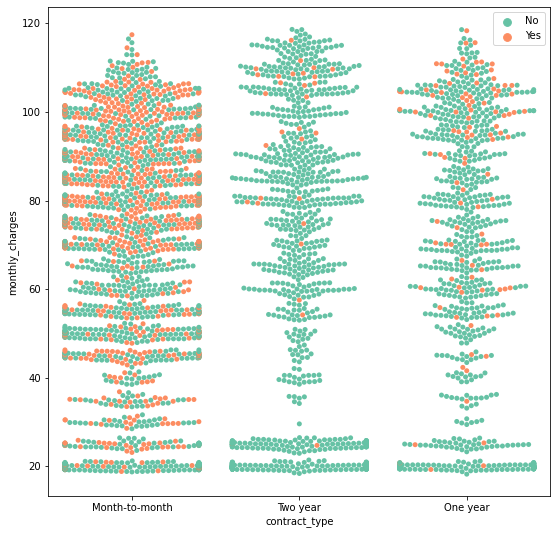

In [12]:
figure(figsize=(9,9))
sns.swarmplot(x="contract_type", y="monthly_charges", data=train, hue="churn", palette="Set2")
plt.legend()

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Contract type and either the customer churn or not is independent
- $H_a$ Contract type and either the customer churn or not is not independent

In [11]:
# crosstab Contract type vs. Churn

observed = pd.crosstab(train.contract_type, train.churn)
observed

churn             No   Yes
contract_type             
Month-to-month  1433  1058
One year         811   107
Two year        1060    31

In [12]:
# Set our alpha

alpha = 0.05

In [13]:
# chi2_contingency returns 4 different values

from scipy import stats
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [14]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[1433 1058]
 [ 811  107]
 [1060   31]]
---
Expected

[[1828  662]
 [ 674  243]
 [ 801  289]]
---

chi^2                 = 742.2653
p                     = 0.0000
degree of freedom     = 2


In [15]:
if p < alpha:
    print("We reject the hypothesis that contract type and either a customer churn or not is independent")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that contract type and either a customer churn or not is independent


### Question 2: Does customers who churn has a shorter tenure on average than those who don't?

#### Tenure vs. Monthly Charges by Churn

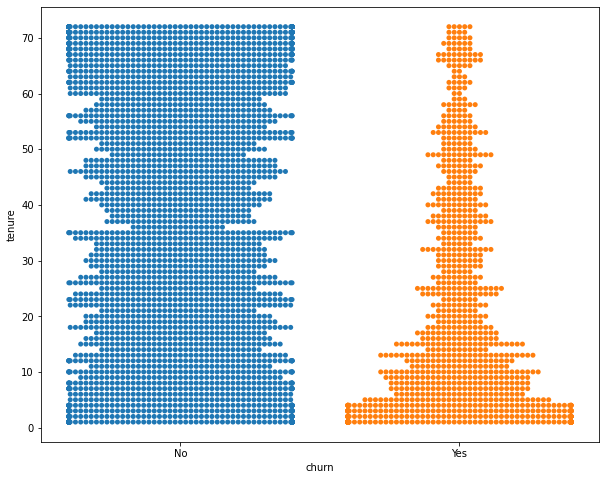

In [21]:
# Visualizing tenure distribution for customers who churn. not churn

plt.figure(figsize=(10,8))
p = sns.swarmplot(
    x="churn",
    y="tenure",
    data=train,
)

#### Statical Testing  - T Test
- $H_0$ Tenure of customers who churned >= Tenure of customers who do not churn
- $H_a$ Tenure of customers who churned < Tenure of customers who do not churn

In [22]:
churn_tenure = train[train['churn']=='Yes'].tenure

In [23]:
no_churn_tenure = train[train['churn']=='No'].tenure

In [25]:
t, p = stats.ttest_ind(churn_tenure,no_churn_tenure, equal_var=False)
t, p/2, alpha

(-27.649600939497784, 8.442633398747043e-148, 0.05)

In [26]:
if p/2 < alpha:
    print("We reject the hypothesis that tenure of customers who churned >= tenure of customers who do not churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that tenure of customers who churned >= tenure of customers who do not churn


In [17]:
# animated graph (changed in final report)

import plotly.express as px
import plotly
import matplotlib
%matplotlib inline

In [295]:
train.head()

customer_id  gender  senior_citizen partner dependents  tenure  \
3118  4472-LVYGI  Female               0     Yes        Yes       0   
2176  3115-CZMZD    Male               0      No        Yes       0   
4054  5709-LVOEQ  Female               0     Yes        Yes       0   
1731  2520-SGTTA  Female               0     Yes        Yes       0   
2025  2923-ARZLG    Male               0     Yes        Yes       0   

     phone_service    multiple_lines      online_security  \
3118            No  No phone service                  Yes   
2176           Yes                No  No internet service   
4054           Yes                No                  Yes   
1731           Yes                No  No internet service   
2025           Yes                No  No internet service   

            online_backup    device_protection         tech_support  \
3118                   No                  Yes                  Yes   
2176  No internet service  No internet service  No internet service   
4054                  Yes                  Yes                   No   
1731  No internet service  No internet service  No internet service   
2025  No internet service  No internet service  No internet service   

             streaming_tv     streaming_movies paperless_billing  \
3118                  Yes                   No               Yes   
2176  No internet service  No internet service                No   
4054                  Yes                  Yes                No   
1731  No internet service  No internet service                No   
2025  No internet service  No internet service               Yes   

      monthly_charges  total_charges churn contract_type  \
3118            52.55            0.0    No      Two year   
2176            20.25            0.0    No      Two year   
4054            80.85            0.0    No      Two year   
1731            20.00            0.0    No      Two year   
2025            19.70            0.0    No      One year   

                   payment_type internet_service_type  gender_Male  \
3118  Bank transfer (automatic)                   DSL            0   
2176               Mailed check                  None            1   
4054               Mailed check                   DSL            0   
1731               Mailed check                  None            0   
2025               Mailed check                  None            1   

      partner_Yes  dependents_Yes  phone_service_Yes  multiple_lines_No  \
3118            1               1                  0                  0   
2176            0               1                  1                  1   
4054            1               1                  1                  1   
1731            1               1                  1                  1   
2025            1               1                  1                  1   

      multiple_lines_Yes  online_security_No  online_security_Yes  \
3118                   0                   0                    1   
2176                   0                   0                    0   
4054                   0                   0                    1   
1731                   0                   0                    0   
2025                   0                   0                    0   

      online_backup_No  online_backup_Yes  device_protection_No  \
3118                 1                  0                     0   
2176                 0                  0                     0   
4054                 0                  1                     0   
1731                 0                  0                     0   
2025                 0                  0                     0   

      device_protection_Yes  tech_support_No  tech_support_Yes  \
3118                      1                0                 1   
2176                      0                0                 0   
4054                      1                1                 0   
1731                      0                0                

In [288]:
train.sort_values(by = 'tenure', ascending = True, inplace = True)

In [19]:
tenure_plot = train.sort_values('tenure', ascending = True)

In [290]:
tenure_plot = tenure_plot[tenure_plot.tenure != 0]

In [20]:
tenure_plot.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [21]:
tenure_plot['churn_bool'] = np.where(tenure_plot.churn == 'No', 0, 1)

In [22]:
fig = px.scatter(
    data_frame=tenure_plot, 
    x = 'churn_Yes',
    y="monthly_charges", 
    animation_frame="tenure", 
    size = 'monthly_charges',
    hover_name="monthly_charges", 
    facet_col="churn",
    size_max=45,
    range_y = [0,150]
)
fig.update_layout(
  template='plotly_dark')
fig.show()

### Question 3. Are customers with Fiber optic internet service more likely to churn?

#### Internet Service Type vs. Churn

In [31]:
train.groupby('internet_service_type').churn.value_counts()

internet_service_type  churn
DSL                    No       1246
                       Yes       290
Fiber optic            No       1164
                       Yes       825
None                   No        901
                       Yes        81
Name: churn, dtype: int64

<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

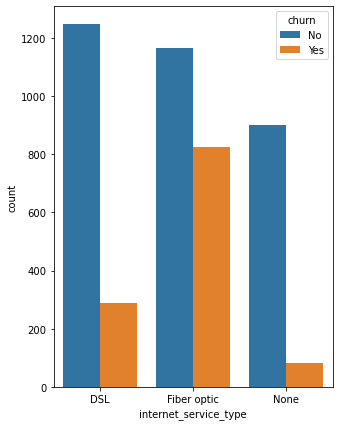

In [32]:
figure(figsize=(5,7))
sns.countplot(x="internet_service_type", data=train, hue="churn")

In [33]:
# t test
fiber_sample = train[train['internet_service_type_Fiber optic']==1].churn_Yes
no_fiber_sample = train[train['internet_service_type_Fiber optic']==0].churn_Yes

In [34]:
t, p = stats.ttest_ind(fiber_sample,no_fiber_sample, equal_var=False)
t, p/2, alpha

(20.391428960778267, 1.035757329211184e-87, 0.05)

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Customers with Fiber optic internet service is independent with their likelihood to churn
- $H_a$ Customers with Fiber optic internet service is not independent with their likelihood to churn

In [35]:
# Crosstab Internet Service Type vs Churn

observed = pd.crosstab(train['internet_service_type_Fiber optic'], train.churn_Yes)
observed

churn_Yes                             0    1
internet_service_type_Fiber optic           
0                                  2147  371
1                                  1164  825

In [88]:
# Set our alpha

alpha = 0.05

In [36]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [37]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[2147  371]
 [1164  825]]
---
Expected

[[1849  668]
 [1461  527]]
---

chi^2                 = 406.3355
p                     = 0.0000
degree of freedom     = 1


In [38]:
if p < alpha:
    print("We reject the hypothesis that Fiber optice internet service type is independent with customer's likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that Fiber optice internet service type is independent with customer's likelihood to churn


### Question 4. Do customers who churn have a higher average monthly spend than those who don't?

#### Monthly Charges by Churn

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

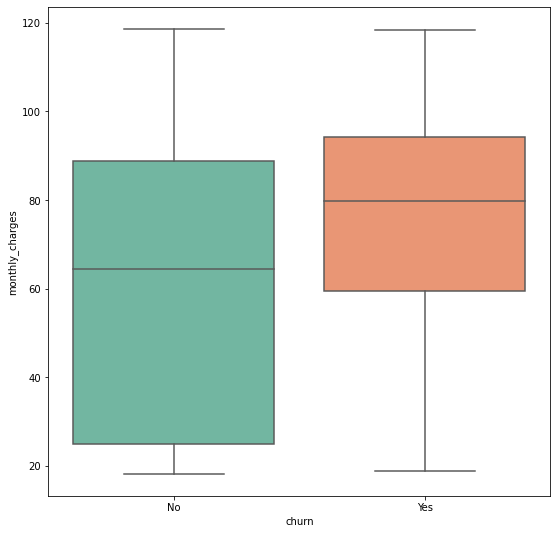

In [18]:
figure(figsize=(9,9))
sns.boxplot(x="churn", y="monthly_charges", data=train, palette="Set2")

#### Statical Testing - 1 tailed T-Test
- $H_0$ Mean of monthly charges of churned customers <= Mean of monthly charges of not churned customers
- $H_a$ Mean of monthly charges of churned customers > Mean of monthly charges of not churned customers

In [19]:
# We decide on 95% confidence level (alpha = 0.05)

alpha = 0.05

In [20]:
# Check distribution normality

train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [42]:
# Calculate t and p statistic

churn_sample = train[train.churn == 'Yes'].monthly_charges
no_churn_sample = train[train.churn == 'No'].monthly_charges

In [43]:
churn_sample.var(), no_churn_sample.var()

(631.2089976560649, 974.354456388164)

In [44]:
t, p = stats.ttest_ind(churn_sample, no_churn_sample, equal_var = False)
t, p/2, alpha

(14.069580970696023, 1.0848081790013175e-43, 0.05)

In [45]:
if (p/2 < alpha) & (t > 0):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


### Question 5. Is device_protection independent with churn?

In [46]:
train.device_protection.value_counts()

No                     1941
Yes                    1584
No internet service     982
Name: device_protection, dtype: int64

In [47]:
train[train.device_protection=='Yes'].churn_Yes.mean()

0.23042929292929293

In [48]:
train[train.device_protection=='No'].churn_Yes.mean()

0.38639876352395675

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Having device protection or not is independent on customers' likelihood to churn
- $H_a$ Having device protection or not is not independent on customers' likelihood to churn

In [36]:
# Crosstab Device Protection vs Churn

observed = pd.crosstab(train['device_protection'], train.churn)

In [37]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [38]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[1187  763]
 [ 915   73]
 [1202  360]]
---
Expected

[[1431  518]
 [ 725  262]
 [1146  415]]
---

chi^2                 = 353.8089
p                     = 0.0000
degree of freedom     = 2


In [39]:
if p < alpha:
    print("We reject the hypothesis that having device protection or not is independent with customers' likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that having device protection or not is independent with customers' likelihood to churn


### Question 6. Is online_security independent with churn?

In [41]:
train.online_security.value_counts()

No                     2212
Yes                    1300
No internet service     988
Name: online_security, dtype: int64

Text(0.5, 1.0, 'Online Security vs. Churn')

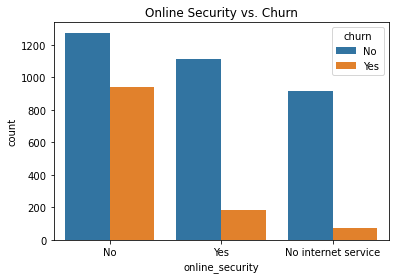

In [40]:
sns.countplot(x="online_security", data=train, hue="churn")
plt.title('Online Security vs. Churn')

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Having online security or not is independent on customers' likelihood to churn
- $H_a$ Having online security or not is not independent on customers' likelihood to churn

In [43]:
observed = pd.crosstab(train.online_security, train.churn)
observed

churn                  No  Yes
online_security               
No                   1274  938
No internet service   915   73
Yes                  1115  185

In [44]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [45]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[1274  938]
 [ 915   73]
 [1115  185]]
---
Expected

[[1624  587]
 [ 725  262]
 [ 954  345]]
---

chi^2                 = 571.9481
p                     = 0.0000
degree of freedom     = 2


In [46]:
if p < alpha:
    print("We reject the hypothesis that having online security or not is independent with customers' likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that having online security or not is independent with customers' likelihood to churn


### Question 7. Is tech_support independent with churn?

In [47]:
train.tech_support.value_counts()

No                     2209
Yes                    1303
No internet service     988
Name: tech_support, dtype: int64

Text(0.5, 1.0, 'Tech Support vs. Churn')

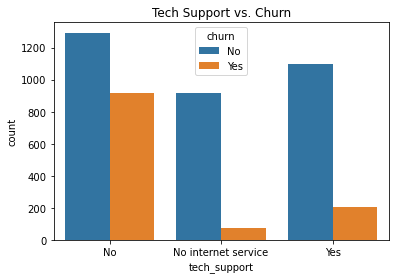

In [48]:
sns.countplot(x="tech_support", data=train, hue="churn")
plt.title('Tech Support vs. Churn')

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Having tech support or not is independent on customers' likelihood to churn
- $H_a$ Having tech support or not is not independent on customers' likelihood to churn

In [35]:
observed = pd.crosstab(train.tech_support, train.churn)
observed

churn                  No  Yes
tech_support                  
No                   1293  916
No internet service   915   73
Yes                  1096  207

In [49]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [50]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[1274  938]
 [ 915   73]
 [1115  185]]
---
Expected

[[1624  587]
 [ 725  262]
 [ 954  345]]
---

chi^2                 = 571.9481
p                     = 0.0000
degree of freedom     = 2


In [51]:
if p < alpha:
    print("We reject the hypothesis that having tech support or not is independent with customers' likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that having tech support or not is independent with customers' likelihood to churn


### Question 8. Is online_backup independent with churn?

Text(0.5, 1.0, 'Online Backup vs. Churn')

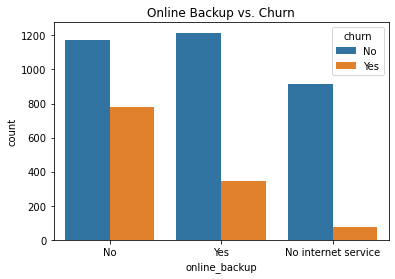

In [52]:
sns.countplot(x="online_backup", data=train, hue="churn")
plt.title('Online Backup vs. Churn')

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Having online backup or not is independent on customers' likelihood to churn
- $H_a$ Having online backup or not is not independent on customers' likelihood to churn

In [53]:
observed = pd.crosstab(train.online_backup, train.churn)
observed

churn                  No  Yes
online_backup                 
No                   1174  779
No internet service   915   73
Yes                  1215  344

In [54]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [55]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[1174  779]
 [ 915   73]
 [1215  344]]
---
Expected

[[1433  519]
 [ 725  262]
 [1144  414]]
---

chi^2                 = 379.9891
p                     = 0.0000
degree of freedom     = 2


In [56]:
if p < alpha:
    print("We reject the hypothesis that having online backup or not is independent with customers' likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that having online backup or not is independent with customers' likelihood to churn


### Question 9. Is payment type independent with churn?

Text(0.5, 1.0, 'Payment Type vs. Churn')

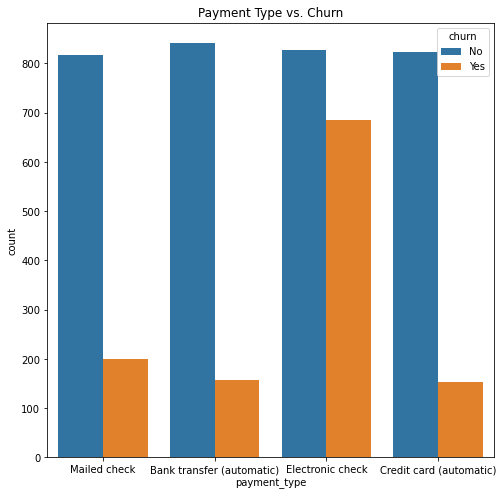

In [132]:
figure(figsize=(8,8))
sns.countplot(x="payment_type", data=train, hue="churn")
plt.title('Payment Type vs. Churn')

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Payment type is independent on customers' likelihood to churn
- $H_a$ Payment type is not independent on customers' likelihood to churn

In [133]:
observed = pd.crosstab(train.payment_type, train.churn)
observed

churn                       No  Yes
payment_type                       
Bank transfer (automatic)  841  158
Credit card (automatic)    824  154
Electronic check           828  685
Mailed check               818  199

In [134]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [135]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2                 = {chi2:.4f}')
print(f'p                     = {p:.4f}')
print(f'degree of freedom     = {dof}')

Observed

[[841 158]
 [824 154]
 [828 685]
 [818 199]]
---
Expected

[[ 733  265]
 [ 718  259]
 [1111  401]
 [ 747  269]]
---

chi^2                 = 415.1391
p                     = 0.0000
degree of freedom     = 3


In [136]:
if p < alpha:
    print("We reject the hypothesis that payment type is independent with customer's likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that payment type is independent with customer's likelihood to churn


### Question 9. Is streaming_tv independent with churn?

Text(0.5, 1.0, 'Streaming TV vs. Churn')

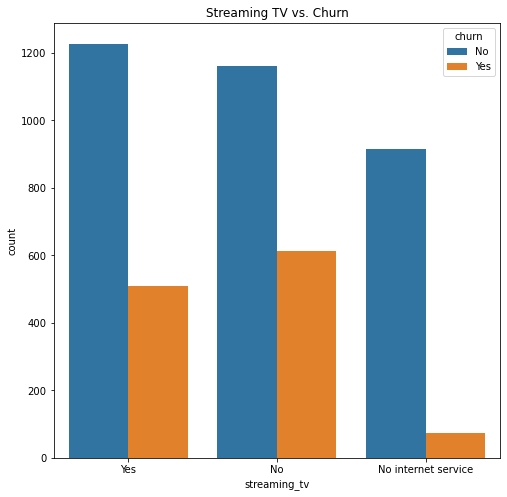

In [77]:
figure(figsize=(8,8))
sns.countplot(x="streaming_tv", data=train, hue="churn")
plt.title('Streaming TV vs. Churn')

#### Statical Testing - Chi$^2$ ($\chi^2$) Test
- $H_0$ Streaming TV is independent on customers' likelihood to churn
- $H_a$ Streaming TV is not independent on customers' likelihood to churn

In [78]:
observed = pd.crosstab(train.streaming_tv, train.churn)
observed

churn                  No  Yes
streaming_tv                  
No                   1162  614
No internet service   915   73
Yes                  1227  509

In [79]:
chi2, p, dof, expected = stats.chi2_contingency(observed)
if p < alpha:
    print("We reject the hypothesis that streaming TV is independent with customer's likelihood to churn")
else:
    print("We fail to reject the null hypothesis")

We reject the hypothesis that streaming TV is independent with customer's likelihood to churn


### Summary: So, who IS most likely to churn?

- Customers who are have **Month-to-month contract**, **Fiber optic internet service type**, **Electronic check**

- Customers who dont' have **online security**, **online backup**, **device protection**, **tech support**

## Predicting Churn

### Baseline Prediction

In [57]:
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [58]:
train['baseline_prediction'] = 'No'

In [59]:
baseline_accuracy = (train.churn == train.baseline_prediction).mean()

In [60]:
print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.42%


## Model 1 - Decision Tree

In [158]:
train.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'payment_type',
       'internet_service_type', 'gender_Male', 'partner_Yes', 'dependents_Yes',
       'phone_service_Yes', 'multiple_lines_No', 'multiple_lines_Yes',
       'online_security_No', 'online_security_Yes', 'online_backup_No',
       'online_backup_Yes', 'device_protection_No', 'device_protection_Yes',
       'tech_support_No', 'tech_support_Yes', 'streaming_tv_No',
       'streaming_tv_Yes', 'streaming_movies_No', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes', 'contract_type_Month-to-month',
       'contract_type_One year', 'contract_type_Two year',
       'payment_type_Bank transfer (automatic)',
       'payment_type

In [83]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [249]:
# split data
columns = ['monthly_charges', 'contract_type_One year',
           'contract_type_Two year', 'internet_service_type_Fiber optic',
           'internet_service_type_DSL','payment_type_Credit card (automatic)',
           'payment_type_Electronic check','payment_type_Mailed check','tenure',
           'online_security_Yes', 'online_security_No',
           'online_backup_Yes', 'online_backup_No',
           'device_protection_Yes', 'device_protection_No',
           'tech_support_Yes', 'tech_support_No',
           'streaming_tv_Yes', 'streaming_tv_No',
          'streaming_movies_Yes', 'streaming_movies_No']
X_train = train[columns]
y_train = train.churn

X_validate = validate[columns]
y_validate = validate.churn

X_test = test[columns]
y_test = test.churn

In [214]:
# Create the tree
tree1 = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

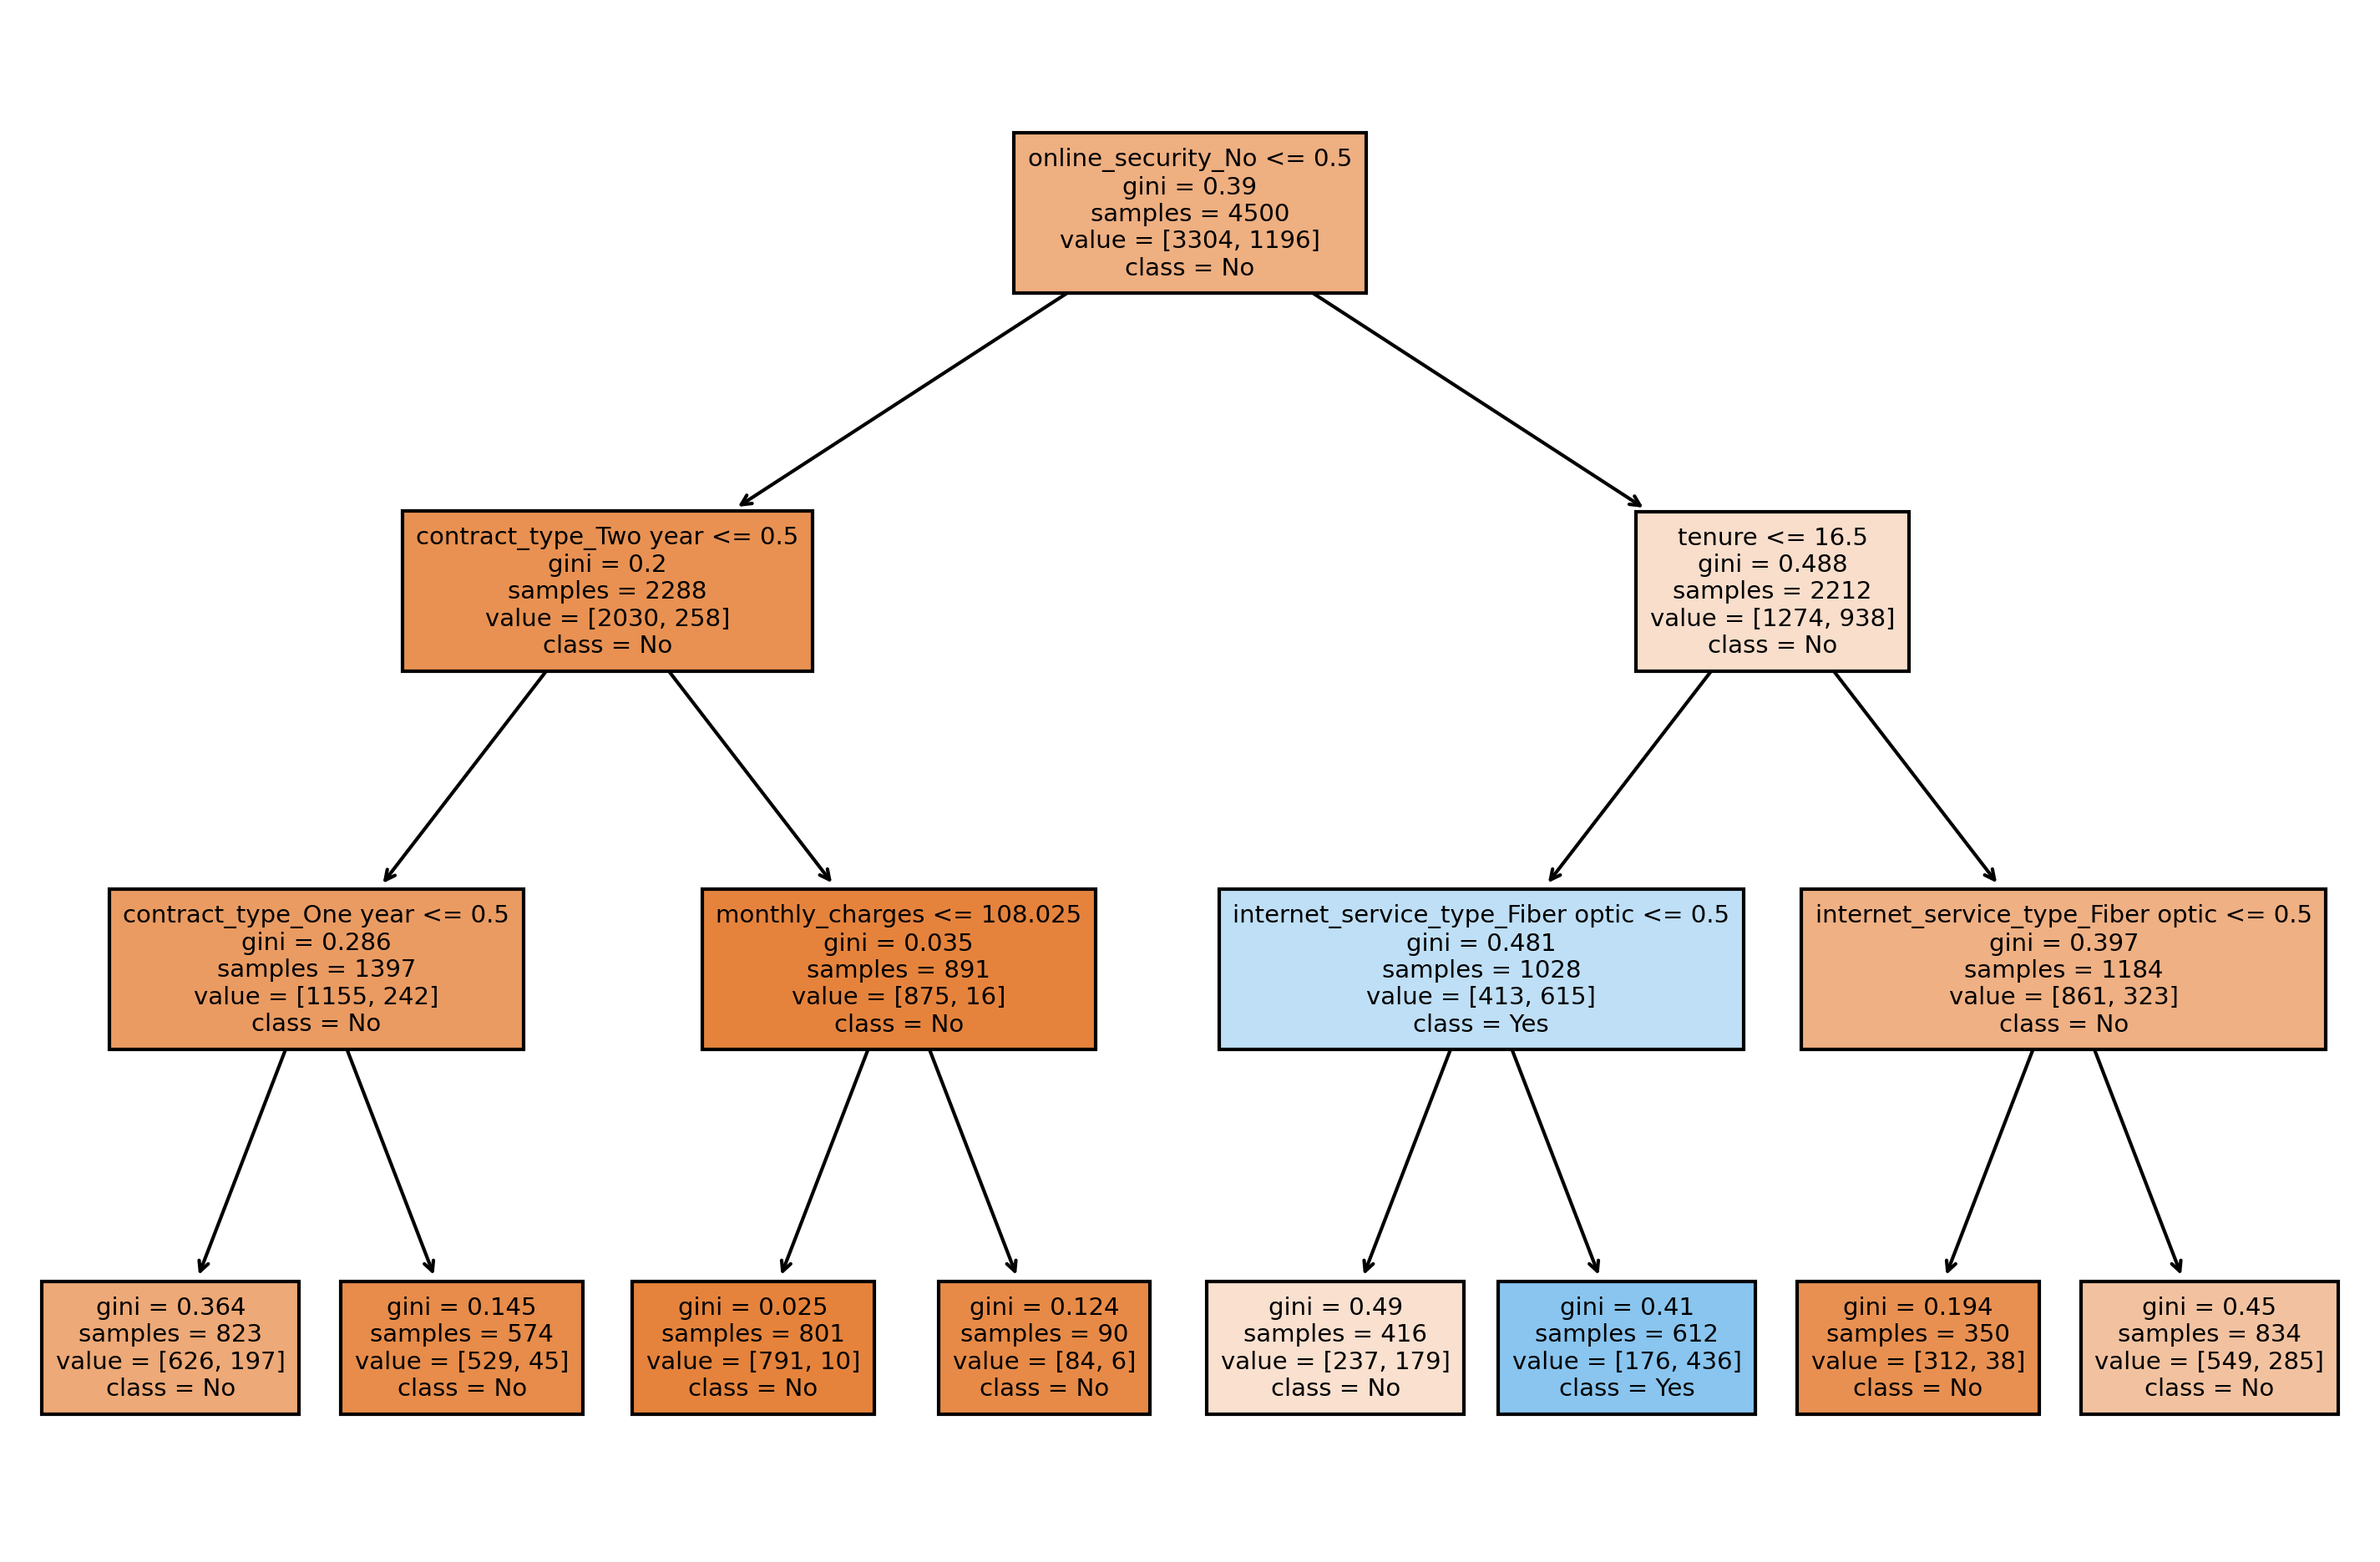

In [215]:
fig, ax = plt.subplots(figsize=(12,8), dpi = 300)
plot_tree(tree1, feature_names=X_train.columns, class_names=y_train.unique(), filled=True, fontsize=7)
plt.show()

In [209]:
# evaluating model

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [216]:
accuracy = pd.crosstab(y_predictions, y_train)
accuracy.reset_index()

churn row_0    No  Yes
0        No  3128  760
1       Yes   176  436

## Model 2 - Decision Tree, exploring max depth

In [217]:
# max depth vs. model score, comparing training & validate datasets
metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df.sort_values(by = ['validate_accuracy', 'difference'], ascending = [False, True])

max_depth  train_accuracy  validate_accuracy  difference
5           6        0.811778           0.782222    0.029556
6           7        0.821333           0.779556    0.041778
3           4        0.796889           0.776000    0.020889
7           8        0.834000           0.776000    0.058000
9          10        0.869333           0.773333    0.096000
2           3        0.792000           0.772444    0.019556
4           5        0.801556           0.769778    0.031778
8           9        0.850444           0.760000    0.090444
1           2        0.779111           0.758222    0.020889
11         12        0.901111           0.746667    0.154444
10         11        0.885556           0.744889    0.140667
13         14        0.930000           0.738667    0.191333
0           1        0.734222           0.734222    0.000000
17         18        0.963333           0.732444    0.230889
12         13        0.917111           0.728000    0.189111
15         16        0.950889           0.728000    0.222889
16         17        0.956222           0.727111    0.229111
18         19        0.967333           0.723556    0.243778
21         22        0.980667           0.723556    0.257111
14         15        0.939333           0.721778    0.217556
22         23        0.985333           0.717333    0.268000
20         21        0.976444           0.716444    0.260000
23         24        0.987778           0.716444    0.271333
19         20        0.972444           0.715556    0.256889

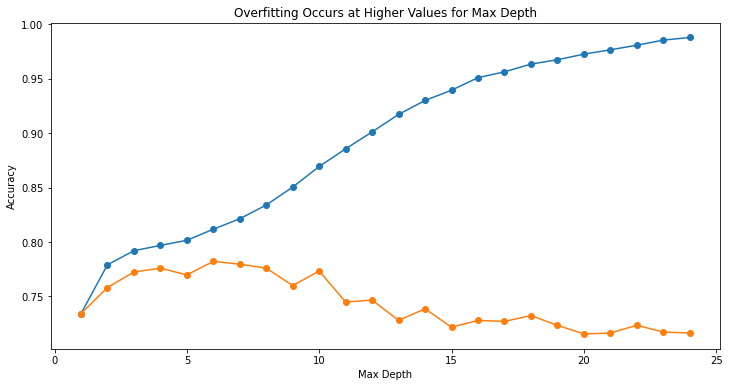

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

### max depth = 6 has the best performance

In [256]:
# Create the tree
tree6 = DecisionTreeClassifier(max_depth=6, random_state=123)

# Fit the model (on train and only train)
tree6 = tree6.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree6.predict(X_train)

In [257]:
# evaluating model

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree6.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.81


## Model 3 - Random Forest, max depth = 3

In [ ]:
# Using the same split for X_train, y_train

In [221]:
# Make the model
forest1 = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of depth 3")
pd.DataFrame(report)

Tree of depth 3


No          Yes  accuracy    macro avg  weighted avg
precision     0.799543     0.726297  0.790444     0.762920      0.780076
recall        0.953692     0.339465  0.790444     0.646579      0.790444
f1-score      0.869841     0.462678  0.790444     0.666260      0.761626
support    3304.000000  1196.000000  0.790444  4500.000000   4500.000000

In [222]:
# loop through max_depth, compare train vs. validate performance
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df.sort_values(by = ['validate_accuracy', 'difference'], ascending = [False, True])

max_depth  train_accuracy  validate_accuracy  difference
6           8        0.826000           0.783111    0.042889
5           7        0.816889           0.782222    0.034667
3           5        0.800667           0.779556    0.021111
4           6        0.812667           0.779556    0.033111
2           4        0.796000           0.778667    0.017333
7           9        0.847333           0.776889    0.070444
8          10        0.875778           0.774222    0.101556
1           3        0.790444           0.772444    0.018000
18         20        0.992667           0.772444    0.220222
10         12        0.932889           0.771556    0.161333
21         23        0.992889           0.768889    0.224000
9          11        0.905111           0.768000    0.137111
12         14        0.973333           0.768000    0.205333
20         22        0.992889           0.768000    0.224889
22         24        0.992889           0.768000    0.224889
16         18        0.992222           0.767111    0.225111
19         21        0.992667           0.767111    0.225556
14         16        0.987778           0.766222    0.221556
0           2        0.771778           0.764444    0.007333
15         17        0.991111           0.764444    0.226667
17         19        0.992667           0.763556    0.229111
11         13        0.960000           0.762667    0.197333
13         15        0.983333           0.762667    0.220667

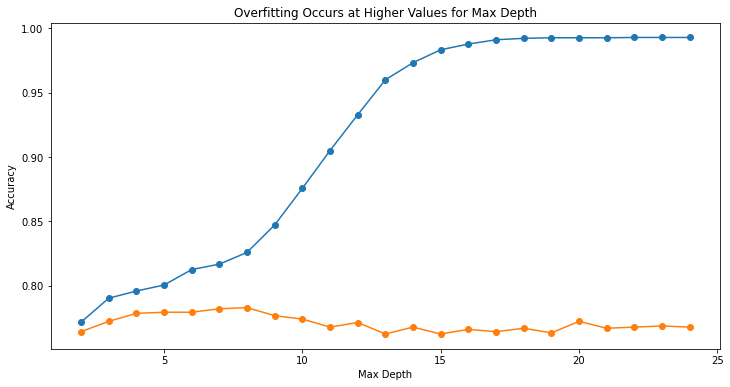

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

## Model 4 - Random Forest, max depth = 8

### max depth = 8 has the best performance

In [224]:
# Make the model
forest8 = RandomForestClassifier(max_depth=6, random_state=123)

# Fit the model (on train and only train)
forest8.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest8.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of depth 8")
pd.DataFrame(report)

Tree of depth 8


No          Yes  accuracy    macro avg  weighted avg
precision     0.838328     0.704519  0.812667     0.771424      0.802765
recall        0.922821     0.508361  0.812667     0.715591      0.812667
f1-score      0.878548     0.590578  0.812667     0.734563      0.802012
support    3304.000000  1196.000000  0.812667  4500.000000   4500.000000

TP = Customer churn, Predict churn

TN = Customer not churn, Predict not churn

FP = Customer not churn, Predict churn

FN = Customer churn, predict not churn

In [225]:
pd.DataFrame(confusion_matrix(y_predictions, y_train))

0    1
0  3049  588
1   255  608

In [226]:
# We decided that 1 is positive and 0 is negative
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(608, 3049, 255, 588)

In [227]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.8126666666666666
True Positive Rate: 0.5083612040133779
False Positive Rate: 0.07717917675544794
True Negative Rate: 0.9228208232445521
False Negative Rate: 0.4916387959866221
Precision: 0.7045191193511008
Recall: 0.5083612040133779
F1 Score: 0.590577950461389
Support (0): 1196
Support (1): 3304


## Model 5 - KNN, k = 1

In [228]:
# knn classifier with n_neighbour = 1

knn1 = KNeighborsClassifier(1)
knn1.fit(X_train, y_train)
# get_classification_metrics(knn)
y_pred = knn1.predict(X_train)

In [229]:
knn1.score(X_train, y_train)

0.9924444444444445

In [230]:
print('Actual on Left, Predicted on Top')
pd.crosstab(y_train, y_pred)

Actual on Left, Predicted on Top


col_0    No   Yes
churn            
No     3283    21
Yes      13  1183

In [231]:
report = classification_report(y_train, y_pred, output_dict=True)
print("n_neighbour = 1")
pd.DataFrame(report)

n_neighbour = 1


No          Yes  accuracy    macro avg  weighted avg
precision     0.996056     0.982558  0.992444     0.989307      0.992468
recall        0.993644     0.989130  0.992444     0.991387      0.992444
f1-score      0.994848     0.985833  0.992444     0.990341      0.992452
support    3304.000000  1196.000000  0.992444  4500.000000   4500.000000

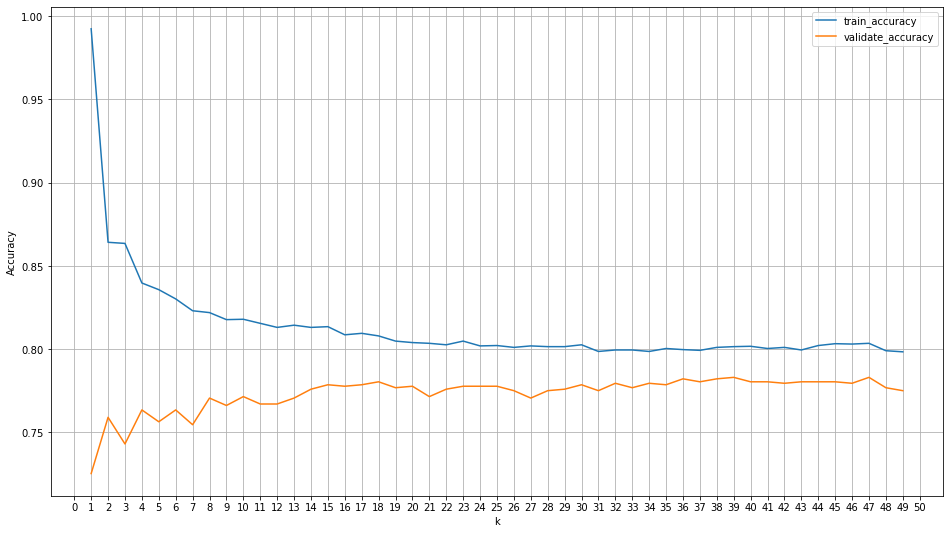

In [233]:
# finding k for best performance for train & validate

metrics = []

# loop through different values of k
for k in range(1, 50):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)

# plot the data
results.set_index('k').plot(figsize = (16,9))
results["difference"] = results.train_accuracy - results.validate_accuracy
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,51,1))
plt.grid()

In [234]:
results.sort_values(by = ['validate_accuracy', 'difference'], ascending = [False, True])

k  train_accuracy  validate_accuracy  difference
38  39        0.801556           0.783111    0.018444
46  47        0.803556           0.783111    0.020444
35  36        0.799778           0.782222    0.017556
37  38        0.801111           0.782222    0.018889
36  37        0.799333           0.780444    0.018889
42  43        0.799556           0.780444    0.019111
40  41        0.800444           0.780444    0.020000
39  40        0.801778           0.780444    0.021333
43  44        0.802222           0.780444    0.021778
44  45        0.803333           0.780444    0.022889
17  18        0.808000           0.780444    0.027556
33  34        0.798667           0.779556    0.019111
31  32        0.799556           0.779556    0.020000
41  42        0.801111           0.779556    0.021556
45  46        0.803111           0.779556    0.023556
34  35        0.800444           0.778667    0.021778
29  30        0.802667           0.778667    0.024000
16  17        0.809556           0.778667    0.030889
14  15        0.813556           0.778667    0.034889
23  24        0.802000           0.777778    0.024222
24  25        0.802222           0.777778    0.024444
19  20        0.804000           0.777778    0.026222
22  23        0.804889           0.777778    0.027111
15  16        0.808667           0.777778    0.030889
47  48        0.799111           0.776889    0.022222
32  33        0.799556           0.776889    0.022667
18  19        0.804889           0.776889    0.028000
28  29        0.801556           0.776000    0.025556
21  22        0.802667           0.776000    0.026667
13  14        0.813111           0.776000    0.037111
48  49        0.798444           0.775111    0.023333
30  31        0.798667           0.775111    0.023556
25  26        0.801111           0.775111    0.026000
27  28        0.801556           0.775111    0.026444
20  21        0.803556           0.771556    0.032000
9   10        0.818000           0.771556    0.046444
26  27        0.802000           0.770667    0.031333
12  13        0.814444           0.770667    0.043778
7    8        0.822000           0.770667    0.051333
11  12        0.813111           0.767111    0.046000
10  11        0.815556           0.767111    0.048444
8    9        0.817778           0.766222    0.051556
5    6        0.830222           0.763556    0.066667
3    4        0.839778           0.763556    0.076222
1    2        0.864222           0.759111    0.105111
4    5        0.835778           0.756444    0.079333
6    7        0.823111           0.754667    0.068444
2    3        0.863556           0.743111    0.120444
0    1        0.992444           0.725333    0.267111

### k = 18 has the best performace

## Model 6 - KNN, k = 18

In [235]:
# knn classifier with n_neighbour = 18

knn18 = KNeighborsClassifier(32)
knn18.fit(X_train, y_train)
# get_classification_metrics(knn)
y_pred = knn18.predict(X_train)

In [236]:
knn18.score(X_train, y_train)

0.7995555555555556

In [237]:
report = classification_report(y_train, y_pred, output_dict=True)
print("n_neighbour = 18")
# pd.DataFrame(report)

n_neighbour = 18


In [238]:
report

{'No': {'precision': 0.8279628618241398,
  'recall': 0.9176755447941889,
  'f1-score': 0.8705139247774907,
  'support': 3304},
 'Yes': {'precision': 0.6754176610978521,
  'recall': 0.47324414715719065,
  'f1-score': 0.5565388397246805,
  'support': 1196},
 'accuracy': 0.7995555555555556,
 'macro avg': {'precision': 0.7516902614609959,
  'recall': 0.6954598459756898,
  'f1-score': 0.7135263822510856,
  'support': 4500},
 'weighted avg': {'precision': 0.7874197373644419,
  'recall': 0.7995555555555556,
  'f1-score': 0.787066324394566,
  'support': 4500}}

In [239]:
# knn classifier with n_neighbour = 8, validate

knn18 = KNeighborsClassifier(32)
knn18.fit(X_validate, y_validate)
# get_classification_metrics(knn)
y_pred = knn18.predict(X_validate)

In [240]:
knn18.score(X_validate, y_validate)

0.776

## Model 7 - Logistic Regression, C = 1

In [250]:
logit1 = LogisticRegression(random_state = 123, C = 1)
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [251]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_validate, y_validate)))

Accuracy of Logistic Regression classifier on training set: 0.78


In [252]:
# choosing C

# create a function first for a single c
def evaluate_model(c):
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    accuracy = model.score(X_validate, y_validate)
    coefs = dict(zip(X_train.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

# loop through different c values
models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]


(pd.DataFrame(models).round(3)
 .set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of different C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3)
)

## Model 8 - Logistic Regression, C  = 0.01

In [253]:
# Train

logit2 = LogisticRegression(random_state = 123, C = 0.01)
logit2.fit(X_train, y_train)
y_pred = logit2.predict(X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.3f}'
     .format(logit2.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.796


In [254]:
# Validate


y_pred = logit2.predict(X_validate)
print('Accuracy of Logistic Regression classifier on validate set: {:.3f}'
     .format(logit2.score(X_validate, y_validate)))

Accuracy of Logistic Regression classifier on validate set: 0.784


## Top 3 Models:
- Decision Tree, max_depth = 6
- Random Forest, max_depth = 8
- Logistic Regression, C = 0.01

### Random Forest Model

In [258]:
print('Accuracy of Random Forest classifier on training set: {:.3f}'
      .format(forest8.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on validate set: {:.3f}'
      .format(forest8.score(X_validate, y_validate)))
print('Accuracy of Random Forest classifier on test set: {:.3f}'
      .format(forest8.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.813
Accuracy of Random Forest classifier on validate set: 0.780
Accuracy of Random Forest classifier on test set: 0.800


### Decision Tree Model

In [259]:
print('Accuracy of Decision Tree classifier on training set: {:.3f}'
      .format(tree6.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.3f}'
      .format(tree6.score(X_validate, y_validate)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
      .format(tree6.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.812
Accuracy of Decision Tree classifier on validate set: 0.782
Accuracy of Decision Tree classifier on test set: 0.798


### Logistic Regression Model

In [260]:
print('Accuracy of Logistic Regression classifier on training set: {:.3f}'
      .format(logit2.score(X_train, y_train)))
print('Accuracy of Logistic Regression classifier on validate set: {:.3f}'
      .format(logit2.score(X_validate, y_validate)))
print('Accuracy of Logistic Regression classifier on test set: {:.3f}'
      .format(logit2.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on training set: 0.796
Accuracy of Logistic Regression classifier on validate set: 0.784
Accuracy of Logistic Regression classifier on test set: 0.805


## Make predictions, csv file

In [262]:
# Make predictions, export csv file

df1 = acquire.get_telco_data()
df1 = prepare.prep_telco(df1)

In [263]:
columns = ['monthly_charges', 'contract_type_One year',
           'contract_type_Two year', 'internet_service_type_Fiber optic',
           'internet_service_type_DSL','payment_type_Credit card (automatic)',
           'payment_type_Electronic check','payment_type_Mailed check','tenure',
           'online_security_Yes', 'online_security_No',
           'online_backup_Yes', 'online_backup_No',
           'device_protection_Yes', 'device_protection_No',
           'tech_support_Yes', 'tech_support_No',
           'streaming_tv_Yes', 'streaming_tv_No',
          'streaming_movies_Yes', 'streaming_movies_No']

In [265]:
telco_prediction = df1[columns]

In [266]:
probability = logit2.predict_proba(telco_prediction)
probability = pd.DataFrame(probability, columns = ['churn-no', 'churn-yes'])

In [267]:
prediction = logit2.predict(telco_prediction)
prediction = pd.DataFrame(prediction)

In [269]:
customer_id = df1['customer_id']
customer_id = pd.DataFrame(customer_id).reset_index(drop=True)
customer_id['predictions'] = logit2.predict(telco_prediction)
customer_id['churn_probability'] = probability['churn-yes']

In [270]:
customer_id.to_csv('telco_classification_churn_prediction.csv', index = False)